In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import string
from collections import Counter
from argparse import Namespace
import json
from torch.nn import functional as F
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/splitted-poems/famous_poems_split.csv
/kaggle/input/splitted-poems/surnames_with_splits.csv
/kaggle/input/splitted-poems/famous_poems_cleaned_single_string_splitted.csv
/kaggle/input/cleaning-poems/__results__.html
/kaggle/input/cleaning-poems/famous_poems_cleaned_single_string.csv
/kaggle/input/cleaning-poems/famous_poems_cleaned.csv
/kaggle/input/cleaning-poems/__notebook__.ipynb
/kaggle/input/cleaning-poems/__output__.json
/kaggle/input/cleaning-poems/custom.css


This work is inspired by inspired by Natural Language Processing in Pytorch by Delip Rao and Brian McMahan.

max  14287
min  222
mean  1040.0833333333333
median  595.5
std  2089.359160457792


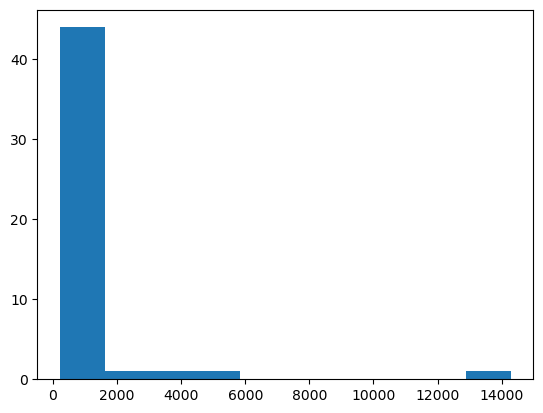

In [2]:
%matplotlib inline
poems_df = pd.read_csv('/kaggle/input/cleaning-poems/famous_poems_cleaned_single_string.csv')

length = []
for poem in poems_df['poem_body']:
    length.append(len(poem))
length = np.array(length)
print("max ", np.max(length))
print("min ", np.min(length))
print("mean ", np.mean(length))
print("median ", np.median(length))
print("std ", np.std(length))
plt.hist(length)
plt.show()

We see that the maximum length of character is 14287. Using that maximum sequence length as in the book of Delip Rao and Brian McMahan will make us run into vanishing gradient. Also, most of the poems in the dataset have a length between 222 and 2000 as we can see on the plot. It is better to subdivide the sequences into smaller sequences so we do not run into vanishing gradient, and we will also keep the number of padding sequence to the minimum.

## Creating the vocabulary
    It consists of all the unique tokens (here characters) in the dataset and their respective count.

In [3]:
class Vocabulary:
    """
    class to process text and extract Vocabulary (tokens in the text) 
    for mapping (tokens => integer)
    """
    def __init__(self, token_to_idx = None, add_unk = True, unk_token = '<UNK>'):
        """
        Args:
            token_to_idx: a dict mapping tokens to indices, if you already have a particular mapping
            add_unk: a boolean indicating to add or not the unk_token '<UNK>'
            unk_token: the token used to represent and process unknown token, what we will add into the vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token,idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = -1
        
        if add_unk:
            self.unk_index = self.add_token(unk_token)
            
    def to_serializable(self):
        """
        returns a dictionary that can be serialized
        """
        return {'token_to_idx': self._token_to_idx, 'add_unk': self._add_unk,
                   'unk_token': self._unk_token}
    
    @classmethod
    def from_serializable(cls, contents):
        """
        instantiates the Vocabulary from a serialized dictionary
        """
        return cls(**contents)
    
    def add_token(self, token):
        """
        Updates mapping dict based on token
        
        Args:
            token (str): the item to be added to the Vocabulary
        Returns:
            index (int): the integer corresponding to the token in the mapping
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self, token):
        """
        Retrieves the index of token in the mapping, or return the index of
        UNK if it isn't present
        Args:
            token (str): the token to look up for
        Returns:
        index (str): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality
        """
        if self.add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
        
    def lookup_index(self,index):
        """
        Returns the token associated with index
        Args: 
            index (int): the index to look up for
        Returns:
            token (str): the token associated with index
        Raises:
            KeyError if index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):
        return len(self._token_to_idx)

In [4]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, add_unk = True,unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        #print(token)
        #print(type(token))
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

# Creating the Vectorizer
The Vectorizer is in charge of transforming the text dataset into vectors to process. 
Since we are training to generate poems, we want the model to predict the sequence of
characters we are training him on, that is why we split the vectors into two lists vectors: 
* from_vectors; the observations;
* to_vectors, the targets. 
They are vectors of integers given by the mapping of SequenceVocabulary. 

Here, we subdivide the input sequence into subsequences of length subsequence_length and group them into the lists from_vectors and to_vectors. We do this to prevent vanishing gradient from sequences that are too long. 

In [5]:
class PoemVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, char_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps words to integers
            
        """
        self.char_vocab = char_vocab
        
    def vectorize(self, poem, subsequence_length=64, stride=1):
        """Vectorize a poem into a vector of observations and targets
        
        The outputs are the vectorized poem split into subsequences:
            poem[:-1] and poem[1:]
        At each timestep, the first vector is the observation and the second vector is the target. 
        
        Args:
            poem (str): the poem to be vectorized
            subsequence_length (int): length of each subsequence
            stride (int): stride for overlapping subsequences
        Returns:
            a tuple of lists: (from_vectors, to_vectors)
            from_vectors (list of numpy.ndarray): list of observation vectors 
            to_vectors (list of numpy.ndarray): list of target prediction vectors
        """
        indices = [self.char_vocab.begin_seq_index] 
        indices.extend(self.char_vocab.lookup_token(token) for token in poem)
        indices.append(self.char_vocab.end_seq_index)
        len_indices = len(indices)
        
        if subsequence_length < 0:
            subsequence_length = len_indices - 1

        num_subsequences = (len_indices - 1) // subsequence_length
        total_length = num_subsequences * subsequence_length
        
        from_indices = [indices[i:i+subsequence_length] for i in range(0, total_length, stride)]
        to_indices = [indices[i+1:i+subsequence_length+1] for i in range(0, total_length, stride)]
        # Pad subsequences to have the same length
        max_length = max(len(subseq) for subseq in from_indices)
        from_indices = [subseq + [self.char_vocab.mask_index] * (max_length - len(subseq)) for subseq in from_indices]
        to_indices = [subseq + [self.char_vocab.mask_index] * (max_length - len(subseq)) for subseq in to_indices]


        from_vectors = np.array(from_indices, dtype=np.int64)
        to_vectors = np.array(to_indices, dtype=np.int64)
        assert from_vectors.shape == to_vectors.shape
        
        return from_vectors, to_vectors



    @classmethod
    def from_dataframe(cls, poem_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            poem_df (pandas.DataFrame): the poem dataset
        Returns:
            an instance of the PoemVectorizer
        """
        char_vocab = SequenceVocabulary()
        #author_vocab = Vocabulary()

        for index, row in poem_df.iterrows():
            for char in row.poem_body:
                char_vocab.add_token(char)
            #author_vocab.add_token(row.author)

        return cls(char_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate the vectorizer from saved contents
        
        Args:
            contents (dict): a dict holding two vocabularies for this vectorizer
                This dictionary is created using `vectorizer.to_serializable()`
        Returns:
            an instance of PoemVectorizer
        """
        
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        #author_vocab =  Vocabulary.from_serializable(contents['author_vocab'])
        

        return cls(char_vocab=char_vocab)

    def to_serializable(self):
        """ Returns the serializable contents """
        return {'char_vocab': self.char_vocab.to_serializable()}#, 
                #'author_vocab': self.author_vocab.to_serializable()


# Extending Pytorch's Dataset class to handle our dataset
    In charge of the loading the dataset, and creating batches from it so our model can train on it.

In [6]:
class PoemDataset(Dataset):
    def __init__(self, poem_df, vectorizer, max_seq_length=-1, subsequence_length=64, stride=1):
        """
        Args:
            poem_df (pandas.DataFrame): the dataset
            vectorizer (PoemVectorizer): vectorizer instatiated from dataset
            max_seq_length (int): the maximum length of the sequence of indices
            subsequence_length (int): subdividing the sequence of indices into smaller ones of length
                                      subsequence_length to prevent vanishing gradient
            stride (int): the amount of overlapping in the subsequence of indices
        """
        self.poem_df = poem_df 
        self._vectorizer = vectorizer

        #self._max_seq_length = max(map(len, self.poem_df.poem_body)) + 2
        self._max_seq_length = max_seq_length
        self._subsequence_length = subsequence_length
        self._stride = stride
        #print("seq length " , self._max_seq_length)
        self.total_char_length = 0

        self.train_df = self.poem_df[self.poem_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.poem_df[self.poem_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.poem_df[self.poem_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, poem_csv,subsequence_length=64,stride=1):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            poem_csv (str): location of the dataset
        Returns:
            an instance of PoemDataset
        """
        
        poem_df = pd.read_csv(poem_csv)
        return cls(poem_df, PoemVectorizer.from_dataframe(poem_df),subsequence_length=subsequence_length,stride=stride)
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, poem_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            poem_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of PoemDataset
        """
        poem_df = pd.read_csv(poem_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(poem_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of PoemVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return PoemVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

        
    def __getitem__(self, index):
        row = self.poem_df.iloc[index]

        # Get the poem text
        poem = row.poem_body

        # Vectorize the poem into input and target tensors
        from_vectors, to_vectors = self._vectorizer.vectorize(poem, self._subsequence_length, self._stride)

        samples = [{'x_data': from_vector, 'y_target': to_vector} for from_vector, to_vector in zip(from_vectors, to_vectors)]

        return samples

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        if self.total_char_length <= 0:
            self.total_char_length = sum(map(len, self.poem_df.poem_body))
        
        return self.total_char_length // (batch_size*self._subsequence_length)
    

def generate_batches(dataset, batch_size, subsequence_length, stride, shuffle=True, drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
    ensure each tensor is on the correct device location.
    """
    dataloader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size,
        shuffle=shuffle, 
        drop_last=drop_last
        # Other DataLoader parameters can be added here, e.g., num_workers, pin_memory, etc.
    )
    
    for data_list in dataloader:
        for data_dict in data_list:
            out_data_dict = {}
            for name,tensor in data_dict.items():
                out_data_dict[name] = tensor.to(device)
            yield out_data_dict


# PoetryGenerationModel

In [7]:
class PoetryGenerationModel(nn.Module):
    def __init__(self, char_embedding_size, char_vocab_size, rnn_hidden_size, 
                 batch_first=True, padding_idx=0, dropout_p=0.5):
        """
        Args:
            char_embedding_size (int): The size of the character embeddings
            char_vocab_size (int): The number of characters to embed
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
            dropout_p (float): the probability of zeroing activations using
                the dropout method.  higher means more likely to zero.
        """
        super(PoetryGenerationModel, self).__init__()
        
        self.char_emb = nn.Embedding(num_embeddings=char_vocab_size,
                                     embedding_dim=char_embedding_size,
                                     padding_idx=padding_idx)

        self.rnn = nn.GRU(input_size=char_embedding_size, 
                          hidden_size=rnn_hidden_size,
                          batch_first=batch_first)
        
        
        self.fc = nn.Linear(in_features=rnn_hidden_size, 
                            out_features=char_vocab_size)
        
        self._dropout_p = dropout_p

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the model
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, char_vocab_size)
        """
        x_embedded = self.char_emb(x_in)

        y_out, _ = self.rnn(x_embedded)

        batch_size, seq_size, feat_size = y_out.shape
        y_out = y_out.contiguous().view(batch_size * seq_size, feat_size)

        y_out = self.fc(F.dropout(y_out, p=self._dropout_p))
                         
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size, seq_size, new_feat_size)
            
        return y_out

In [8]:
class PoetryGenerator:
    """
    Class to handle training and generation 
    """
    def __init__(self, args):
        """
        Args:
            args: all the parameters and hyperparameters of the model and training
        """
        self.args = args
        if self.args.reload_from_files:
            # training from a checkpoint
            self.dataset = PoemDataset.load_dataset_and_load_vectorizer(args.poem_csv,
                                                                      args.vectorizer_file)
        else:
            # create dataset and vectorizer
            self.dataset = PoemDataset.load_dataset_and_make_vectorizer(args.poem_csv, args.subsequence_length, args.stride)
            self.dataset.save_vectorizer(args.vectorizer_file)

        self.vectorizer = self.dataset.get_vectorizer()

        self.model = PoetryGenerationModel(char_embedding_size=args.char_embedding_size,
                                       char_vocab_size=len(self.vectorizer.char_vocab),
                                       rnn_hidden_size=args.rnn_hidden_size,
                                       padding_idx=self.vectorizer.char_vocab.mask_index)
        print("Subsequence length ", self.dataset._subsequence_length)
    
    def sample_from_model(self, num_samples=1, sample_size=20, seed_indices=None, temperature=0.8):
        begin_seq_index = torch.tensor([self.vectorizer.char_vocab.begin_seq_index for _ in range(num_samples)], dtype=torch.int64).unsqueeze(dim=1)

        # If seed_indices are provided, replace the hidden state after the begin_seq
        if seed_indices is not None:
            seed_indices = seed_indices.unsqueeze(0)  # Add batch dimension      
            h_t = seed_indices
        else:
            h_t = None

        indices = [begin_seq_index]
        for time_step in range(sample_size):
            x_t = indices[time_step]
            x_emb_t = self.model.char_emb(x_t)
            if h_t is not None:
                h_t = h_t.to(x_emb_t.dtype)
            rnn_out_t, h_t = self.model.rnn(x_emb_t, h_t)
            prediction_vector = self.model.fc(rnn_out_t.squeeze(dim=1))
            probability_vector = F.softmax(prediction_vector / temperature, dim=1)
            new_indices = torch.multinomial(probability_vector, num_samples=1)
            indices.append(new_indices)

        indices = torch.cat(indices, dim=1)  # Concatenate the list of tensors along the second dimension
        return indices

    def decode_samples(self, sampled_indices):
        """Transform indices into the string form of a poem

        Args:
            sampled_indices (torch.Tensor): the inidces from `sample_from_model`
            
        """
        decoded_poem = []
        vocab = self.vectorizer.char_vocab

        for sample_index in range(sampled_indices.shape[0]):
            poem = ""
            for time_step in range(sampled_indices.shape[1]):
                sample_item = sampled_indices[sample_index, time_step].item()
                if sample_item == vocab.begin_seq_index:
                    continue
                elif sample_item == vocab.end_seq_index:
                    break
                else:
                    poem += vocab.lookup_index(sample_item)
            decoded_poem.append(poem)
        return decoded_poem
    
    def make_train_state(self):
        return {'stop_early': False,
                'early_stopping_step': 0,
                'early_stopping_best_val': 1e8,
                'learning_rate': self.args.learning_rate,
                'epoch_index': 0,
                'train_loss': [],
                'train_acc': [],
                'val_loss': [],
                'val_acc': [],
                'test_loss': -1,
                'test_acc': -1,
                'model_filename': self.args.model_state_file}

    def update_train_state(self, train_state):
        """Handle the training state updates.
        Components:
         - Early Stopping: Prevent overfitting.
         - Model Checkpoint: Model is saved if the model is better

        :param train_state: a dictionary representing the training state values
        :returns:
            a new train_state
        """

        # Save one model at least
        if train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), train_state['model_filename'])
            train_state['stop_early'] = False

        # Save model if performance improved
        elif train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= loss_tm1:
                # Update step
                train_state['early_stopping_step'] += 1
            # Loss decreased
            else:
                # Save the best model
                if loss_t < train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), train_state['model_filename'])
                    train_state['early_stopping_best_val'] = loss_t

                # Reset early stopping step
                train_state['early_stopping_step'] = 0

            # Stop early ?
            train_state['stop_early'] = \
                train_state['early_stopping_step'] >= self.args.early_stopping_criteria

        return train_state

    def normalize_sizes(self, y_pred, y_true):
        """Normalize tensor sizes

        Args:
            y_pred (torch.Tensor): the output of the model
                If a 3-dimensional tensor, reshapes to a matrix
            y_true (torch.Tensor): the target predictions
                If a matrix, reshapes to be a vector
        """
        if len(y_pred.size()) == 3:
            y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
        if len(y_true.size()) == 2:
            y_true = y_true.contiguous().view(-1)
        return y_pred, y_true

    def compute_accuracy(self, y_pred, y_true, mask_index):
        y_pred, y_true = self.normalize_sizes(y_pred, y_true)

        _, y_pred_indices = y_pred.max(dim=1)

        correct_indices = torch.eq(y_pred_indices, y_true).float()
        valid_indices = torch.ne(y_true, mask_index).float()

        n_correct = (correct_indices * valid_indices).sum().item()
        n_valid = valid_indices.sum().item()

        return n_correct / n_valid * 100

    def sequence_loss(self, y_pred, y_true, mask_index):
        y_pred, y_true = self.normalize_sizes(y_pred, y_true)
        return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)
    
    def training(self):
        """
        Training loop
        """
        mask_index = self.vectorizer.char_vocab.mask_index

        self.model = self.model.to(self.args.device)

        optimizer = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)
        self.train_state = self.make_train_state()

        try:
            for epoch_index in range(self.args.num_epochs):
                self.train_state['epoch_index'] = epoch_index

                # Print current epoch and early stopping criteria
                print(f"Epoch {epoch_index+1}/{self.args.num_epochs}")
                print(f"Early Stopping Criteria: {self.args.early_stopping_criteria}")

                # Iterate over training dataset

                # setup: batch generator, set loss and acc to 0, set train mode on
                self.dataset.set_split('train')
                batch_generator = generate_batches(self.dataset, 
                                                   batch_size=self.args.batch_size,
                                                   subsequence_length = self.args.subsequence_length,
                                                   stride = self.args.stride,
                                                   device=self.args.device)
                running_loss = 0.0
                running_acc = 0.0
                self.model.train()
                #max_idx = 0
                #for batch_index, batch_dict in enumerate(batch_generator):
                    #print(batch_dict)
                    #if batch_index > max_idx:
                        #max_idx = batch_index

                for batch_index, batch_dict in enumerate(batch_generator):
                    
                    # the training routine is these 5 steps:

                    # --------------------------------------    
                    # step 1. zero the gradients
                    optimizer.zero_grad()

                    # step 2. compute the output
                    y_pred = self.model(x_in=batch_dict['x_data'])

                    # step 3. compute the loss
                    loss = self.sequence_loss(y_pred, batch_dict['y_target'], mask_index)

                    # step 4. use loss to produce gradients
                    loss.backward()

                    # step 5. use optimizer to take gradient step
                    optimizer.step()
                    # -----------------------------------------
                    # compute the  running loss and running accuracy
                    running_loss += (loss.item() - running_loss) / (batch_index + 1)
                    acc_t = self.compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
                    running_acc += (acc_t - running_acc) / (batch_index + 1)

                    # Print current loss and accuracy
                    print(
                          f"Loss: {running_loss:.4f}, Accuracy: {running_acc:.2f}%")

                self.train_state['train_loss'].append(running_loss)
                self.train_state['train_acc'].append(running_acc)

                # Iterate over val dataset

                # setup: batch generator, set loss and acc to 0; set eval mode on
                self.dataset.set_split('val')
                batch_generator = generate_batches(self.dataset, 
                                                   batch_size=args.batch_size,
                                                   subsequence_length = self.args.subsequence_length,
                                                   stride = self.args.stride,
                                                   device=args.device)
                running_loss = 0.
                running_acc = 0.
                self.model.eval()

                for batch_index, batch_dict in enumerate(batch_generator):
                    # compute the output
                    y_pred = self.model(x_in=batch_dict['x_data'])

                    # step 3. compute the loss
                    loss = self.sequence_loss(y_pred, batch_dict['y_target'], mask_index)

                    # compute the  running loss and running accuracy
                    running_loss += (loss.item() - running_loss) / (batch_index + 1)
                    acc_t = self.compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
                    running_acc += (acc_t - running_acc) / (batch_index + 1)

                self.train_state['val_loss'].append(running_loss)
                self.train_state['val_acc'].append(running_acc)

                self.train_state = self.update_train_state(train_state=self.train_state)

                scheduler.step(self.train_state['val_loss'][-1])

                if self.train_state['stop_early']:
                    break

                # move model to cpu for sampling
                self.model = self.model.cpu()
                sampled_poem = self.decode_samples(
                    self.sample_from_model( num_samples=2))
                # Show results
                print("-" * 15)
                for i in range(2):
                    print(sampled_poem[i])
                # move model back to whichever device it should be on
                self.model = self.model.to(self.args.device)

        except KeyboardInterrupt:
            print("Exiting loop")

    def evaluate_test(self):
        # compute the loss & accuracy on the test set using the best available model

        self.model.load_state_dict(torch.load(self.train_state['model_filename']))

        self.model = self.model.to(self.args.device)

        self.dataset.set_split('test')
        batch_generator = generate_batches(self.dataset, 
                                           batch_size=self.args.batch_size,
                                           subsequence_length = self.args.subsequence_length,
                                           stride = self.args.stride,
                                           device=self.args.device)
        running_acc = 0.
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = self.model(x_in=batch_dict['x_data'])

            # compute the loss
            loss = self.sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss 
        self.train_state['test_acc'] = running_acc 
        print("Test loss: {};".format(train_state['test_loss']))
        print("Test Accuracy: {}".format(train_state['test_acc']))

    def generate_poem(self, seed_word, num_poems=10, sample_size=50):
        """
        Generate a poem starting from a seed word.

        Args:
            seed_word (str): The seed word for poem generation.
            num_poems (int): Number of poems to generate.
            sample_size (int): The max length of the samples.

        Returns:
            None
        """
        self.model = self.model.cpu()

        # Vectorize the seed word
        if seed_word:
            seed_indices = self.vectorize_seed_word(seed_word, num_poems)

        else:
            seed_indices = None

        # Generate poem using the initial hidden state
        sampled_poem = self.decode_samples(
            self.sample_from_model(num_samples=num_poems, sample_size=sample_size, seed_indices=seed_indices)
        )

        # Show generated poems
        print("-" * 15)
        for i in range(num_poems):
            print(sampled_poem[i])

    def vectorize_seed_word(self, seed_word, num_poems):
        """Vectorize the seed word using the vectorizer.

        Args:
            seed_word (str): The seed word.

        Returns:
            torch.Tensor: The vectorized seed word indices.
        """
        seed_indices = [self.vectorizer.char_vocab.lookup_token(char) for char in seed_word]
        # Pad the sequence to match the size of the hidden state
        while len(seed_indices) < self.model.rnn.hidden_size:
            seed_indices.append(self.vectorizer.char_vocab.mask_index)
        seed_indices = torch.tensor(
            [seed_indices for _ in range(num_poems)],
            dtype=torch.long
        )
        return seed_indices


# General utilities

In [9]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# Settings and preparation

In [16]:
args = Namespace(
    # Data and Path information
    poem_csv="/kaggle/input/splitted-poems/famous_poems_split.csv",
    #poem_csv="/kaggle/input/splitted-poems/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch7/model1_unconditioned_poem_generation",
    # Model hyper parameters
    char_embedding_size=128,
    rnn_hidden_size=128,
    subsequence_length = 64,
    stride = 1,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=1,
    num_epochs=5,
    early_stopping_criteria=15,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch7/model1_unconditioned_poem_generation/vectorizer.json
	model_storage/ch7/model1_unconditioned_poem_generation/model.pth
Using CUDA: False


# Testing the classes

In [11]:
def test_poem_dataset_class(poem_csv, vectorizer_file):
    # Test loading dataset and vectorizer
    dataset = PoemDataset.load_dataset_and_make_vectorizer(poem_csv)
    assert isinstance(dataset, PoemDataset)

    # Save the vectorizer
    dataset.save_vectorizer(vectorizer_file)

    # Load dataset with existing vectorizer
    dataset = PoemDataset.load_dataset_and_load_vectorizer(poem_csv, vectorizer_file)
    assert isinstance(dataset, PoemDataset)

    # Test get_vectorizer method
    vectorizer = dataset.get_vectorizer()
    assert isinstance(vectorizer, PoemVectorizer)

    # Test set_split and __len__ methods
    dataset.set_split('train')
    assert len(dataset) == dataset.train_size

    dataset.set_split('val')
    assert len(dataset) == dataset.validation_size

    dataset.set_split('test')
    assert len(dataset) == dataset.test_size

    print("PoemDataset class tests passed.")

def test_generate_batches(poem_csv, vectorizer_file, batch_size, device):
    # Load dataset with existing vectorizer
    dataset = PoemDataset.load_dataset_and_load_vectorizer(poem_csv, vectorizer_file)

    # Set split and test generate_batches
    dataset.set_split('train')
    batches = generate_batches(dataset, batch_size, subsequence_length = 64, stride = 1, device=device)
    max_idx = 0

    for idx,batch in enumerate(batches):
        #print(batch)
        # Check if all tensors are on the correct device
        for key, value in batch.items():
            #print(len(key), value.size())
            #print(key)
            #print(value)
            assert value.device.type == device

    print("generate_batches function test passed.")

# Specify paths and parameters
poem_csv = '/kaggle/input/splitted-poems/famous_poems_split.csv'
vectorizer_file = 'vectorizer.json'
batch_size = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Run the tests
test_poem_dataset_class(poem_csv, vectorizer_file)
test_generate_batches(poem_csv, vectorizer_file, batch_size, device)


PoemDataset class tests passed.
generate_batches function test passed.


In [17]:
poem_gen = PoetryGenerator(args)
poem_gen.training()

Subsequence length  64
Epoch 1/5
Early Stopping Criteria: 15
Loss: 4.3116, Accuracy: 0.00%
Loss: 4.2625, Accuracy: 0.00%
Loss: 4.2044, Accuracy: 2.08%
Loss: 4.1639, Accuracy: 3.12%
Loss: 4.1181, Accuracy: 7.19%
Loss: 4.0814, Accuracy: 9.64%
Loss: 4.0405, Accuracy: 12.72%
Loss: 3.9957, Accuracy: 16.80%
Loss: 3.9550, Accuracy: 18.58%
Loss: 3.9123, Accuracy: 21.41%
Loss: 3.8691, Accuracy: 23.15%
Loss: 3.8270, Accuracy: 24.48%
Loss: 3.7859, Accuracy: 26.08%
Loss: 3.7419, Accuracy: 27.01%
Loss: 3.6910, Accuracy: 28.02%
Loss: 3.6443, Accuracy: 28.81%
Loss: 3.6013, Accuracy: 29.32%
Loss: 3.5568, Accuracy: 29.77%
Loss: 3.5114, Accuracy: 30.02%
Loss: 3.4710, Accuracy: 30.47%
Loss: 3.4266, Accuracy: 30.65%
Loss: 3.3853, Accuracy: 30.97%
Loss: 3.3463, Accuracy: 31.11%
Loss: 3.3075, Accuracy: 31.32%
Loss: 3.2716, Accuracy: 31.50%
Loss: 3.2402, Accuracy: 31.85%
Loss: 3.2135, Accuracy: 31.77%
Loss: 3.1863, Accuracy: 32.03%
Loss: 3.1620, Accuracy: 32.22%
Loss: 3.1388, Accuracy: 32.34%
Loss: 3.1124, A

In [19]:
poem_gen.generate_poem(num_poems=1, sample_size = 340, seed_word = "Love is ")

---------------
; And An did see th an him cr pepthe Lupercal I thrice presented hin him apr hen he was ac presenthe Lupercal Did the Brutus in him hit on the presentel I that on the presentus his an him aa I thic pept: An the coural I thrice presend, hi Len he thon the Lupercal I thrcint cresentutu crienercal I thrice prneses him a kingly crind ghe pres


In [20]:
poem_gen.generate_poem(num_poems=1, sample_size = 340, seed_word = None)

---------------
; And thic presened thic Yee I the Luperc crinof seeptus him a kingly crcend the Len an him al did the Lunercal I thrice presaercal I thrine Brutus le man. You al I thrice presed the Lupercal cris hima bitious; And thrae Luneral I thrice presented hion senty Call I thrin he Luperce preneral I thrice presentunercal I thrice presented hat o


# Next steps:

* Evaluating the outputs:
    Make a score of how "good" the outputed poem is. We will use the number of correct words first, and extend to see for grammatical correctness.
* Fine-tuning the model: find better hyperparameters to maximize the score previously discussed.
* Conditioning the output:
    Scrape more poems, group them by categories( author, subject), and better condition the output based on the author and the subject.